# Load cleaned Topography

## Call from HDD

In [1]:
import numpy as np
import pandas as pd
arrSries  = pd.Series()
fns = ['2HTaSe2_bad_78K097','2HTaSe2_ap_118K002','2HTaSe2_bae_110K012','2HTaSe2_ao_115K037','test']

for fn in fns:
    arrSries[fn] = np.load(f'{fn}_cln.npy')

## Manually defined parameter

In [2]:
colors = ['#9467bd','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
nms = ['78K(1)', '118K', '110K', '115K','78K(2)']
Ts = [78, 118, 110, 115,78]
nano = [160,40,80,40,80]
sz = [2048,512,1024,1024,2048]


In [3]:
df = pd.DataFrame({
    'fns': fns,
    'colors': colors,
    'nms': nms,
    'Ts': Ts,
    'nano': nano,
    'sz': sz
})
df

,fns,colors,nms,Ts,nano,sz
0,2HTaSe2_bad_78K097,#9467bd,78K(1),78,160,2048
1,2HTaSe2_ap_118K002,#1f77b4,118K,118,40,512
2,2HTaSe2_bae_110K012,#ff7f0e,110K,110,80,1024
3,2HTaSe2_ao_115K037,#2ca02c,115K,115,40,1024
4,test,#d62728,78K(2),78,80,2048


# Topography

In [4]:
from useful import *
tab = subtabSr(arrSries)

d:\github\2H_TaSe2_Tc_STM\2Hvenv\Lib\site-packages\numpy\lib\_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


## Topography:large,tab

In [5]:
tab

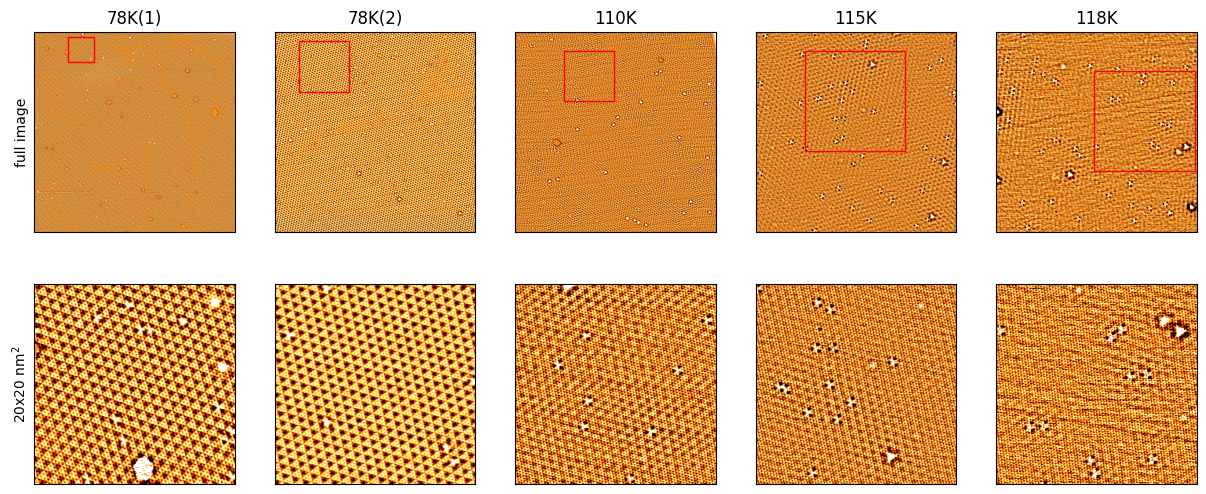

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
idts = [0,4,2,3,1]
x0, y0 = 250, 100
x0_, y0_ = 350, 50
x0s = [x0_,x0,x0,x0,x0]
y0s = [y0_,y0,y0,y0,y0]

fig,axs = plt.subplots(2,5,figsize=(15,6))
for idt,isb,x0,y0 in zip(idts,range(len(idts)),x0s,y0s):
    ax = axs[0,isb]
    plt.sca(ax)    
    arr = arrSries[fns[idt]]
    plt.imshow(arr,cmap='afmhot')
    auto199()
    tickoff()
    ax.set_title(df['nms'][idt])
    pxl20nm = int((sz[idt]/nano[idt]) *20)
    if isb == 0:
        ax.set_ylabel('full image')
    
    ax = axs[1,isb]
    plt.sca(ax)    
    plt.imshow(arr,cmap='afmhot')
    auto199()
    tickoff()    
    ax.set_xlim(x0,pxl20nm+x0)
    ax.set_ylim(y0,pxl20nm+y0)
    if isb == 0:
        ax.set_ylabel('20x20 nm$^2$')
from matplotlib.patches import Rectangle
for idt, isb, x0, y0 in zip(idts, range(len(idts)), x0s, y0s):
    ax = axs[0, isb]
    pxl20nm = int((sz[idt] / nano[idt]) * 20)
    rect = Rectangle((x0, y0), pxl20nm, pxl20nm, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# To see the result, you need to execute the next cell (12) to create the plot first,
# and then come back and execute this cell.
# The figure object `fig` needs to be displayed to see the changes.
# fig

# FFT

## manual define peak

### fcns

In [7]:
from scipy.fft import fft2, fftshift
from skimage.feature import peak_local_max
def fft2show(arr_cln,vmin,vmax):
  fft_result = fft2(arr_cln)
  fft_result_shifted = fftshift(fft_result)
  magnitude_spectrum = np.abs(fft_result_shifted)
  plt.figure(figsize=(10, 10))
  plt.imshow(magnitude_spectrum, cmap='gray', vmin=vmin, vmax=vmax)
  plt.title('Magnitude Spectrum of 2D FFT')
  return  magnitude_spectrum
def fft2pkfnd(fft2abs,threshold,choose):
  coordinates = peak_local_max(fft2abs, min_distance=100, threshold_abs = threshold)
  plt.scatter(coordinates[:, 1], coordinates[:, 0], s=50, facecolors='none', edgecolors='r')
  for ipeak in range(coordinates.shape[0]):
    plt.text(coordinates[ipeak,1],coordinates[ipeak,0],str(ipeak), color='g')
  coordinates_choose = coordinates[choose,:]
  print(coordinates_choose)
  print(coordinates_choose.shape[0])
  for ipeak in range(coordinates_choose.shape[0]):
    plt.text(coordinates_choose[ipeak,1],coordinates_choose[ipeak,0],str(ipeak), color='b',size= 20)
    pk_all = coordinates - (np.array(fft2abs.shape)/2)
    pk_choose = pk_all[choose,:]
  return pk_choose,pk_all

In [8]:
vmin = 0 # @param
vmax = 0.0000001 # @param
threshold = 0#0.0000000001 # @param
choose = [0] # @param

In [9]:
chooses = [
    [7,8,11],
    [1,4,3],
    [1,4,7],
    [1,2,5],
    [7,2,5]
]

In [10]:
%matplotlib inline
arrsz =[]
ffts = []
pk_chooses = []
for fn,choose in zip(fns,chooses):
    arr_cln = arrSries[fn]
    arrsz.append(arr_cln.shape)
    fft2abs = fft2show(arr_cln,vmin,vmax)
    pk_choose,pk_all = fft2pkfnd(fft2abs,threshold,choose)
    pk_chooses.append(pk_choose)
    ffts.append(plt.gcf()) 
    plt.close()
        

[[1138 1547]
 [ 494  847]
 [1450  679]]
3
[[274 398]
 [111 208]
 [382 162]]
3
[[559 793]
 [216 417]
 [763 327]]
3
[[543 654]
 [363 464]
 [630 418]]
3
[[1076 1282]
 [ 747  937]
 [1249  854]]
3


In [12]:
# %matplotlib qt
subtabs(ffts,fns)

## FFT profile

### fcns

In [13]:
from scipy.ndimage import map_coordinates

def get_line_profile(img, p1, p2, num_points):
    """
    Get the line profile of a 2D image between two points p1 and p2.
    
    Args:
        img (np.ndarray): The 2D image.
        p1 (tuple): The (y, x) coordinates of the start point.
        p2 (tuple): The (y, x) coordinates of the end point.
        num_points (int): The number of points for interpolation.
        
    Returns:
        np.ndarray: The 1D array of intensity values along the line.
    """
    # Generate coordinates along the line
    y_coords = np.linspace(p1[0], p2[0], num_points)
    x_coords = np.linspace(p1[1], p2[1], num_points)
    
    # `map_coordinates` expects coordinates in (ndim, n_points) format
    coords = np.vstack((y_coords, x_coords))
    
    # Interpolate the values from the image
    profile = map_coordinates(img, coords, order=1)
    
    return profile

In [32]:
scl = 1.2
atomPos = 1000
len_interp = int(atomPos*scl)#1201
# atomPos = int(1200/scl)
fft_pflss = []
# p1 = [0,0]
for idt in range(len(fns)):
    arr_cln = arrSries.iloc[idt]
    fft_result = fft2(arr_cln)
    fft2abs = fftshift(abs(fft2(arr_cln)))    
    fft_pfls = []
    sz = arrsz[idt]
    p1 = np.array([sz[0]//2,sz[1]//2])
    for of3 in range(3):            
        pk_choose = pk_chooses[idt][of3]        
        p2 = pk_choose*scl + p1
        fft_pfl = get_line_profile(fft2abs, p1, p2, len_interp)        
        fft_pfls.append(fft_pfl)
    fft_pflss.append(fft_pfls)
# plt.plot(foo)

### plot all fft line profile

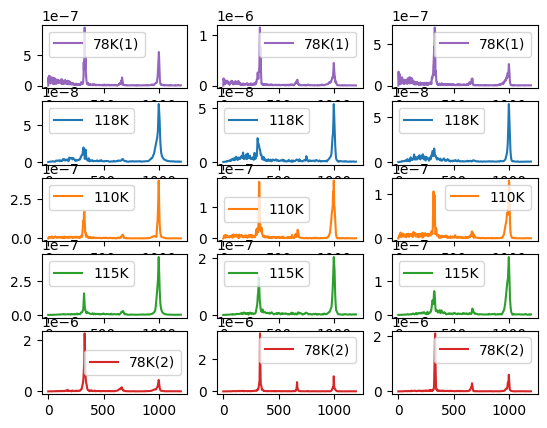

In [15]:
%matplotlib inline
vmin,vmax = 300,360
fig,axs = plt.subplots(5,3)
npamss=[]
npmss =[]
for idt in range(len(fns)):
    npams = []
    npms = []
    for of3 in range(3):
        fft_prof = fft_pflss[idt][of3]            
        axs[idt,of3].plot(fft_prof,color=colors[idt],label=nms[idt])
        npam = np.argmax(fft_prof[vmin:vmax]) + vmin
        npm = np.max(fft_prof[vmin:vmax])/fft_prof[atomPos]
        # axs[idt,of3].plot(npam,npm,'o',color=colors[idt])     
        axs[idt,of3].legend()
        npams.append(npam)
        npms.append(npm)
    npamss.append(npams)
    npmss.append(npms)

### T vs CDW shift

Text(0, 0.5, 'Q (1/nm)')

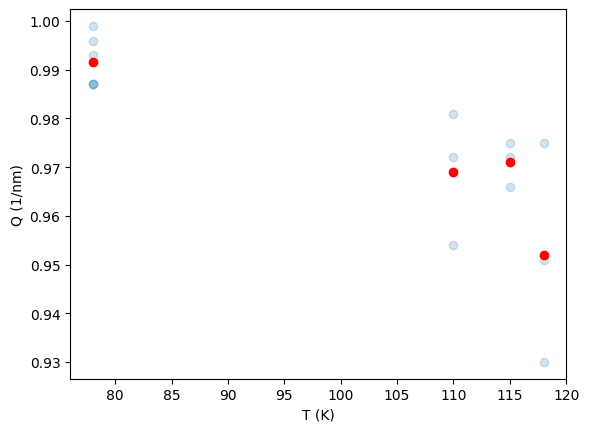

In [16]:
npamavg = np.array(npamss).mean(axis=1)
npmavg = np.array(npmss).mean(axis=1)
npamavT = [(npamavg[0]+npamavg[-1])/2,npamavg[1],npamavg[2],npamavg[3]]
npmavgT = [(npmavg[0]+npmavg[-1])/2,npmavg[1],npmavg[2],npmavg[3]]
xs =[]
ys = []
y2s = []
for idt in range(len(fns)):
    for of3 in range(3):
        xs.append(Ts[idt])
        ys.append(npamss[idt][of3])
        y2s.append(npmss[idt][of3])
ys = np.array(ys)/(1000/3)
# y2s = np.array(y2s)/(1000/3)
npamavT = np.array(npamavT)/(1000/3)
plt.scatter(xs,ys,alpha=0.2)
plt.plot(Ts[:-1],npamavT,'ro')
plt.xlabel('T (K)')
plt.ylabel('Q (1/nm)')

### T vs cdw peak intensity

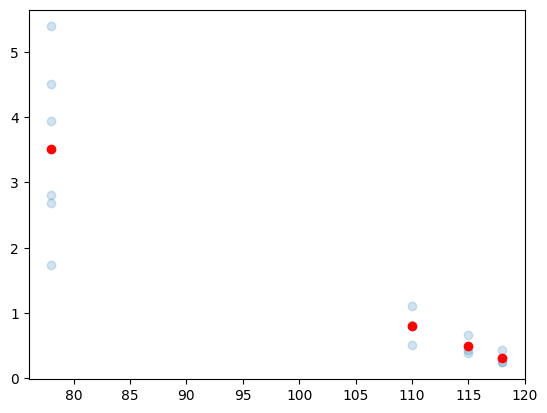

In [17]:
plt.scatter(xs,y2s,alpha=0.2)
plt.plot(Ts[:-1],npmavgT,'ro')


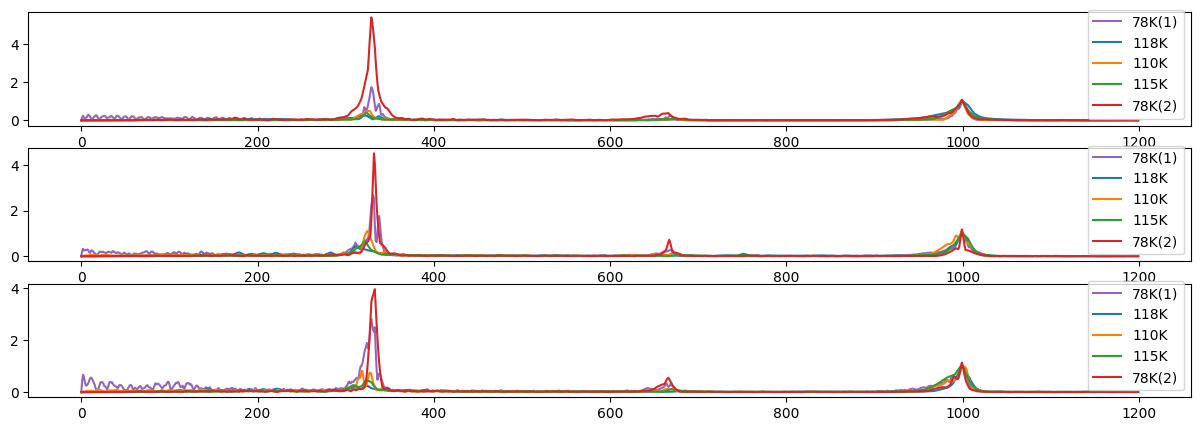

In [18]:
%matplotlib inline
fig,axs = plt.subplots(3,1,figsize=(15,5))
# for idt in range(len(fns)):

# atomPos = int(1200/(scl*3))
for of3 in range(3):
    for idt in range(len(fns)):
    # for idt in [0,1,2,3]:            
        fft_prof = fft_pflss[idt][of3]
        fft_prof_norm = fft_prof/fft_prof[atomPos]
        axs[of3].plot(fft_prof_norm,color=colors[idt],label=nms[idt])
        # axs[of3].set_xlim(300,360)
    # axs[idt,of3].plot(fft_pflss[idt][of3])
    # axs[idt,of3].set_title(fns[idt]+' pk#'+str(of3))
    axs[of3].legend()


np.float64(2.103363477862927e-06)

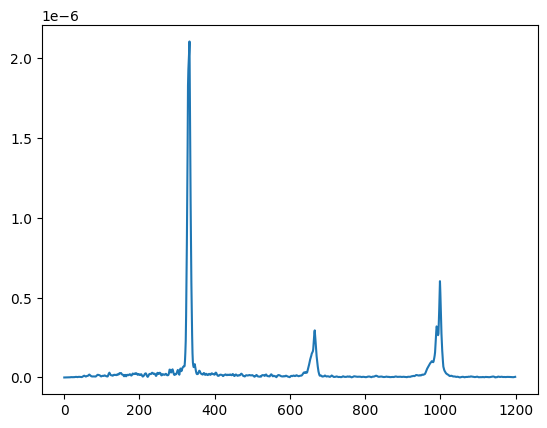

In [19]:
fft_prof = fft_pflss[idt][of3]
vmin,vmax = 300,360
plt.plot(fft_prof)
am = np.argmax(fft_prof[vmin:vmax]) + vmin
np.max(fft_prof[vmin:vmax])

# Autocorrelation

## 2d autocorrelation

In [20]:
import numpy as np

def autocorr2d_fft(arr):
    f = np.fft.fft2(arr)
    psd = f * np.conj(f)   # power spectral density
    result = np.fft.ifft2(psd).real
    return np.fft.fftshift(result)  # 중앙 정렬

In [21]:
auto_corr_ffts = []
auto_corr_fft_figs= []
for ind in range(len(fns)):
    fn = fns[ind]
    arr = arrSries[fn]
    auto_corr_fft = autocorr2d_fft(arr)
    auto_corr_ffts.append(auto_corr_fft)
    fig = plt.figure(figsize=(10,10))
    plt.imshow(auto_corr_fft, cmap='gray')
    auto_corr_fft_figs.append(fig) 
    tickoff()
    cntr = np.array(arr.shape)/2
    plt.xlim(cntr[1]-50,cntr[1]+50)
    plt.ylim(cntr[0]-50,cntr[0]+50)
    plt.close()
    

In [22]:
subtabs(auto_corr_fft_figs,fns)

## autocorr line profile

In [23]:
from scipy.ndimage import map_coordinates

def line_profile(image, p1, p2):
    """
    Get the line profile of a 2D image between two points p1 and p2.
    
    Args:
        image (np.ndarray): The 2D image.
        p1 (tuple): The (y, x) coordinates of the start point.
        p2 (tuple): The (y, x) coordinates of the end point.
        
    Returns:
        np.ndarray: The 1D array of intensity values along the line.
    """
    y1, x1 = p1
    y2, x2 = p2
    
    # Number of points in the line profile
    num_points = int(np.ceil(np.linalg.norm(np.array(p1) - np.array(p2))))
    
    # Generate coordinates along the line
    y_coords = np.linspace(y1, y2, num_points)
    x_coords = np.linspace(x1, x2, num_points)
    
    # `map_coordinates` expects coordinates in (ndim, n_points) format
    coords = np.vstack((y_coords, x_coords))
    
    # Interpolate the values from the image
    profile = map_coordinates(image, coords, order=1)
    
    return profile

# Example usage:
# Define two points for the line profile
# p1 = (1024, 1024)  # Center of the image




In [24]:
p2s =[
    [1038,962],
    [263,200],
    [521,457],
    [537,401],
    [1048,905]
    ]
longness = 1

In [25]:
for idx in range(len(fns)):
    auto_corr_fft = auto_corr_ffts[idx]
    p1 = np.array(auto_corr_fft.shape)/2
    p2 = p2s[idx][1],p2s[idx][0]
    p2 = np.array(p2)
    shift = p2 - p1
    p2 = p1 + shift*longness
    p2s[idx] = [p2[1],p2[0]]


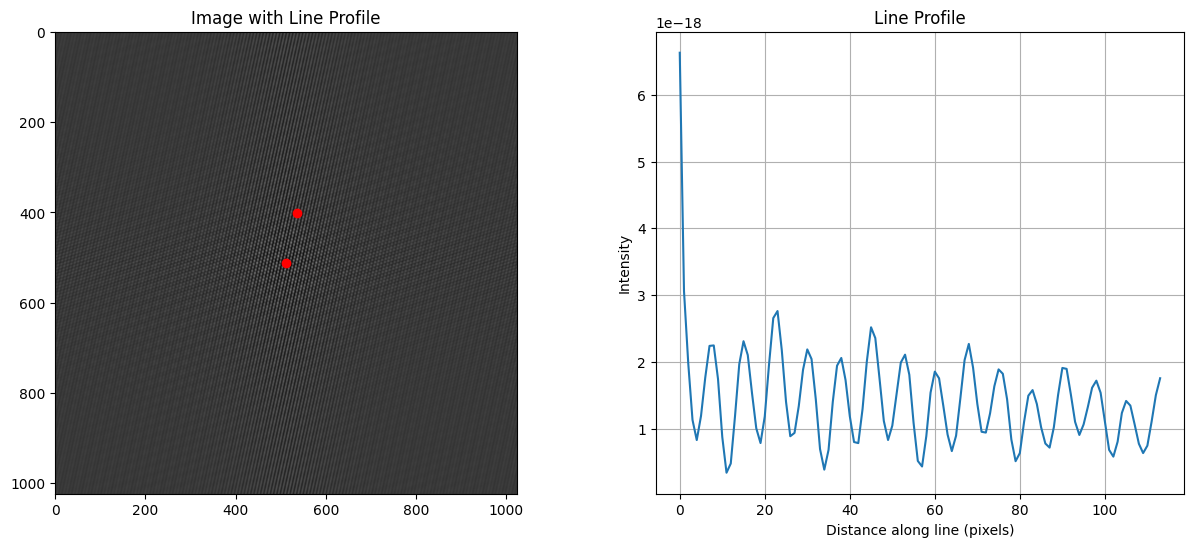

In [26]:
idx =3
auto_corr_fft = auto_corr_ffts[idx]
p1 = np.array(auto_corr_fft.shape)/2
# p2 = (1024 + pk_choose[0, 0], 1024 + pk_choose[0, 1]) # A chosen peak
p2 = p2s[idx][1],p2s[idx][0]
# p2 = np.array(p2)
# # shift = p2 - p1
# # p2 = p1 + shift*2
# crp = 400

# Get the line profile from the auto-correlation image
profile = line_profile(auto_corr_fft, p1, p2)

# Plot the result
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the image with the line
axes[0].imshow(auto_corr_fft, cmap='gray')
axes[0].plot([p1[1], p2[1]], [p1[0], p2[0]], 'ro') # Draw line
axes[0].set_title('Image with Line Profile')
axes[0].axis('image')
cntr = p1
# axes[0].set_xlim(cntr[1]-crp,cntr[1]+crp)
# axes[0].set_ylim(cntr[0]-crp,cntr[0]+crp)

# Plot the line profile
axes[1].plot(profile)
axes[1].set_title('Line Profile')
axes[1].set_xlabel('Distance along line (pixels)')
axes[1].set_ylabel('Intensity')
axes[1].grid(True)

plt.show(block=True)

In [27]:
from scipy.ndimage import map_coordinates

def line_profile(image, p1, p2,num_points=1000):
    """
    Get the line profile of a 2D image between two points p1 and p2.
    
    Args:
        image (np.ndarray): The 2D image.
        p1 (tuple): The (y, x) coordinates of the start point.
        p2 (tuple): The (y, x) coordinates of the end point.
        
    Returns:
        np.ndarray: The 1D array of intensity values along the line.
    """
    y1, x1 = p1
    y2, x2 = p2
    
    # Number of points in the line profile
    # num_points = int(np.ceil(np.linalg.norm(np.array(p1) - np.array(p2))))
    
    # Generate coordinates along the line
    y_coords = np.linspace(y1, y2, num_points)
    x_coords = np.linspace(x1, x2, num_points)
    
    # `map_coordinates` expects coordinates in (ndim, n_points) format
    coords = np.vstack((y_coords, x_coords))
    
    # Interpolate the values from the image
    profile = map_coordinates(image, coords, order=1)
    
    return profile

In [28]:
fcs = [(200/longness)*i for i in range(5*longness+1)]
fcs[-1] = 999

In [29]:
fcs = list(map(int,fcs))

important data point

In [30]:
# def exp_func(x, a, b, c):
#     return a * np.exp(-b * x) + c
# initial_guess = [1.0, 0.01, 0.0]
# def exp_func(x, a, b):
#     return a * np.exp(-b * x)
# initial_guess = [1.0, 0.01]
def exp_func(x,  b):
    return np.exp(-b * x)
initial_guess = [0.01]

[6.83823864]
[2.99232136]
[2.47538195]
[1.05933357]


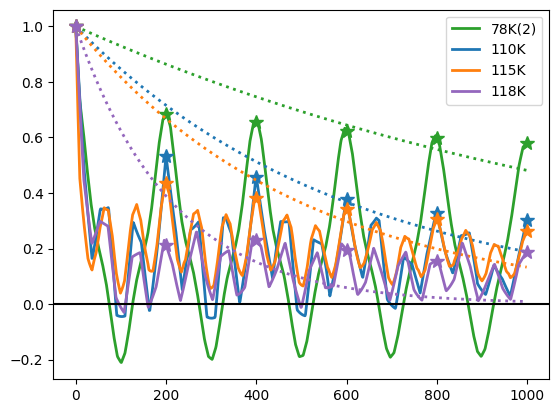

In [35]:
%matplotlib inline
from scipy.optimize import curve_fit
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
# nms = ['78K', '118K', '110K', '115K','78K']
lps = []
lp2s = []
for idt in [4,2,3,1]:
    auto_corr_fft = auto_corr_ffts[idt]
    p1 = np.array(auto_corr_fft.shape)/2
    p2 = p2s[idt][1],p2s[idt][0]
    # p1 = 2*p1 - p2
    lp = line_profile(auto_corr_fft, p1, p2,num_points=1000)
    # lp = profile_line(auto_corr_fft, p1, p2,linewidth=5)
    lp = lp/np.max(lp)
    lps.append(lp)
    lp2 = lp[fcs]
    lp2s.append(lp2)
    popt, pcov = curve_fit(exp_func, np.array(fcs), lp2, p0=initial_guess)
    lp3 = exp_func(range(1000), *popt)
    plt.plot(lp,label=nms[idt],linewidth=2,color=colors[idt-1])
    plt.plot(fcs,lp2,'*',linewidth=2,color=colors[idt-1],markersize=10)
    plt.plot(lp3,':',linewidth=2,color=colors[idt-1])
    print(1/(popt*200))
# plt.vertical_line(0)
plt.legend()    
plt.axhline(0,color='k')